# `AdvectionPer.m`

In [1]:
function u = triangle(N, t)
    %
    % Constructs a periodic triangle wave traveling with a speed of
    % c = 1.
    %
    % Input
    %   N : to compute the mesh size
    %   t : the current time
    %
    % Output
    %   u : the array of values of the function
    %
    h = 1.0 / N;

    for i = 1:N + 1
        x = (i - 1) * h - t;
        x = x - floor(x);

        if x >= 0.25 && x <= 0.50
            u(i) = 4.0 * x - 1.0;
        elseif x > 0.50 && x <= 0.75
            u(i) = 3.0 - 4.0 * x;
        else
            u(i) = 0.0;
        end

    end

end

In [2]:
function u = square(N, t)
    %
    % Constructs a periodic square wave traveling with a speed of
    % c = 1.
    %
    % Input
    %   N : to compute the mesh size
    %   t : the current time
    %
    % Output
    %   u : the array of values of the function
    h = 1.0 / N;

    for i = 1:N + 1
        x = (i - 1) * h - t;
        x = x - floor(x);

        if x <= 0.5
            u(i) = 1.0;
        else
            u(i) = 0.0;
        end

    end

end

In [3]:
function [errorUW, errorLW, errorLF] = AdvectionPer(finalT, ...
        N, K, numPlots, typeInit)
    % This function computes numerical approximations to solutions
    % of the linear advection equation
    %
    % u_t + u_x = 0
    %
    % using the upwind (UW), Lax-Wendroff (LW), and Lax-Friedrichs
    % (LF) methods on the periodic domain [0,1]. The initial data is
    % constructed from either a square or a triangular wave.
    %
    % Input
    %   finalT : the final time
    %   N : the number of spatial grid points in [0,1]
    %   K : the number of time steps in the interval [0,finalT]
    %   numPlots : the number of output frames in the time interval
    %              [0,finalT]. Must be a divisor of K.
    %   typeInit :  is the type of initial condition
    %              = 1 for the Gaussian wave
    %              = 2 for the triangular wave
    %              = 3 for the square wave.
    %
    % Output
    %   errorUW: the max norm error of the UW scheme at t = finalT
    %   errorLW: the max norm error of the LW scheme at t = finalT
    %   errorLF: the max norm error of the LF scheme at t = finalT
    %
    errorUW = 1.0;
    errorLW = 1.0;
    errorLF = 1.0;

    if N > 0 && N - floor(N) == 0
        h = 1.0 / N;
    else
        display('Error: N must be a positive integer.')
        return
    end

    if (K > 0 && K - floor(K) == 0) && finalT > 0
        tau = finalT / K;
    else
        display('Error: K must be a positive integer, and')
        display('       finalT must be positive.')
        return
    end

    mu = tau / h;

    x = 0:h:1.0;
    uo = zeros(1, N + 1);

    if typeInit == 1
        uo = exp(-20 * (sin(pi * (x - 0.5))).^2);
    elseif typeInit == 2
        uo = triangle(N, 0);
    elseif typeInit == 3
        uo = square(N, 0);
    else
        display('No such initial condition.')
        return
    end

    uoUW = zeros(1, N + 1); uUW = zeros(1, N + 1);
    uoLW = zeros(1, N + 2); uLW = zeros(1, N + 2);
    uoLF = zeros(1, N + 2); uLF = zeros(1, N + 2);
    uExact = zeros(1, N + 1);

    uoUW = uo;
    uoLW = uo; uoLW(N + 2) = uo(2);
    uoLF = uo; uoLF(N + 2) = uo(2);

    if mod(K, numPlots) == 0
        stepsPerPlot = K / numPlots;
    else
        display('Error: numPlots is not a divisor of K.')
        return
    end

    for k = 1:numPlots

        for j = 1:stepsPerPlot
            kk = (k - 1) * stepsPerPlot + j;

            for ell = 2:N + 1
                uUW(ell) = (1 - mu) * uoUW(ell) + mu * uoUW(ell - 1);
                uLW(ell) = uoLW(ell) - 0.5 * mu * (uoLW(ell + 1) ...
                    -uoLW(ell - 1)) + 0.5 * mu * mu * (uoLW(ell + 1) ...
                    -2.0 * uoLW(ell) + uoLW(ell - 1));
                uLF(ell) = 0.5 * (uoLF(ell + 1) + uoLF(ell - 1)) ...
                    -0.5 * mu * (uoLF(ell + 1) - uoLF(ell - 1));
            end

            uUW(1) = uUW(N + 1);
            uoUW = uUW;
            uLW(1) = uLW(N + 1); uLW(N + 2) = uLW(2);
            uoLW = uLW;
            uLF(1) = uLF(N + 1); uLF(N + 2) = uLF(2);
            uoLF = uLF;
        end

        currTime = tau * kk;

        if typeInit == 1
            uExact = exp(-20 * (sin(pi * (x - 0.5 - currTime))).^2);
        elseif typeInit == 2
            uExact = triangle(N, currTime);
        elseif typeInit == 3
            uExact = square(N, currTime);
        end

        hf = figure(k);
        clf
        plot(x, uExact, 'k-', x, uUW, 'b-o', x, uLW(1:N + 1), 'r-s', x, ...
            uLF(1:N + 1), 'k-d')
        grid on;
        xlabel('x');
        ylabel('exact and approximate solutions');
        title(['Finite Difference Approximations at T = ', ...
                num2str(currTime), ', h = ', num2str(h), ...
                ', and tau =', num2str(tau)]);
        legend('Exact', 'Upwind', 'Lax--Wendroff', 'Lax--Friedrichs')
        axis([0, 1, -0.1, 1.1])
        set(gca, 'xTick', 0:0.1:1)

        s1 = ['000' num2str(k)];
        s2 = s1((length(s1) - 3):length(s1));
        s3 = ['OUT/adv', s2, '.pdf'];
        %exportgraphics(gca, s3)
    end

    errorUW = max(abs(uExact - uUW));
    errorLW = max(abs(uExact - uLW(1:N + 1)));
    errorLF = max(abs(uExact - uLF(1:N + 1)));
end

In [4]:
finalT = 10;
N = 100;
K = 50;
numPlots = 10;
typeInit = 1;


errorUW = 2.5500e+63
errorLW = 7.2234e+128
errorLF = 6.7932e+56


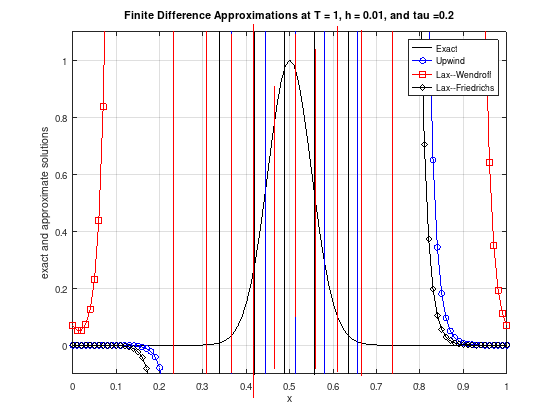

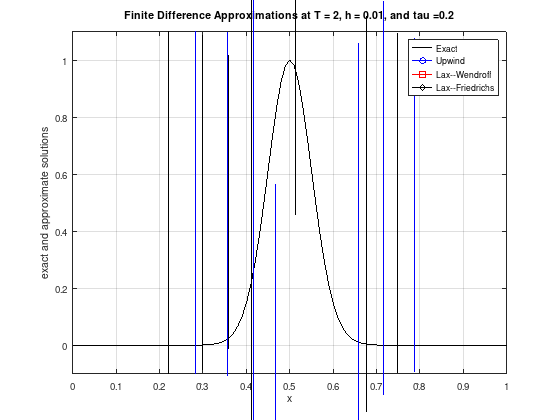

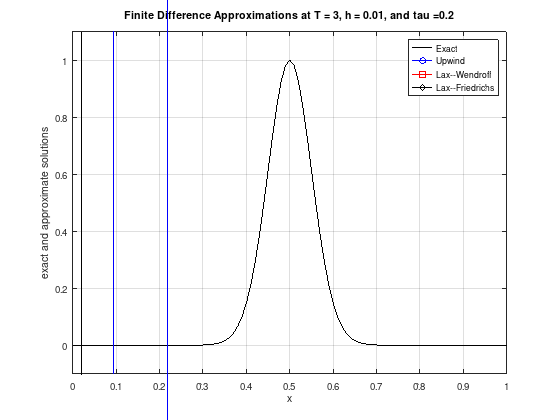

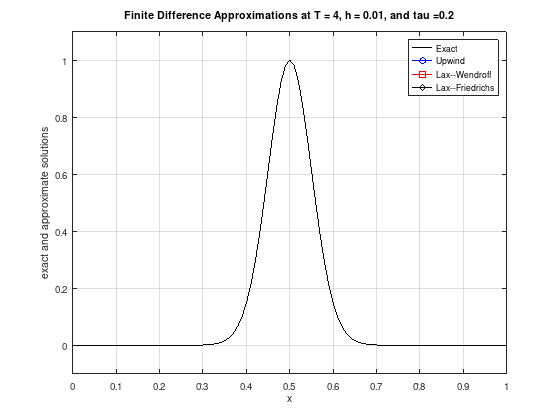

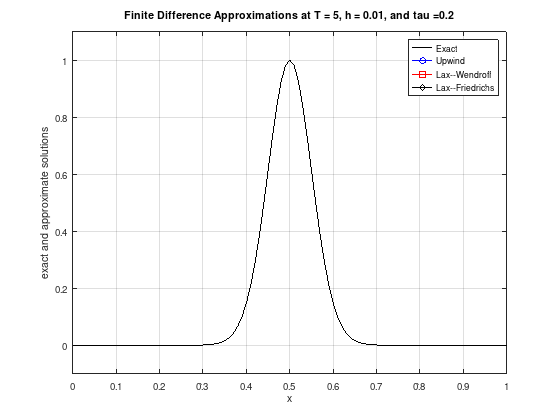

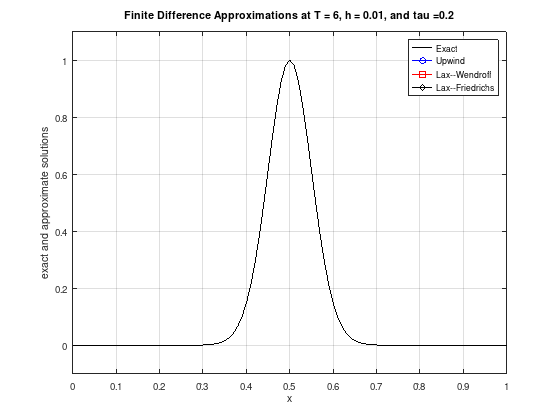

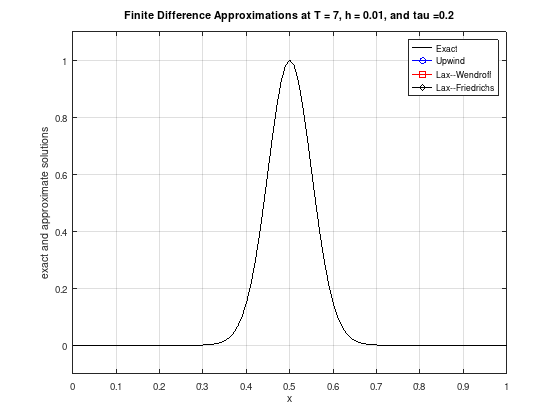

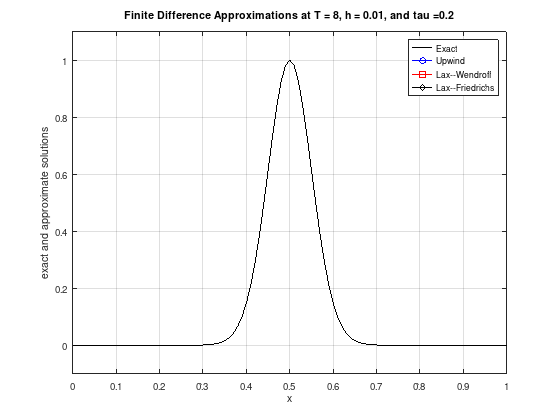

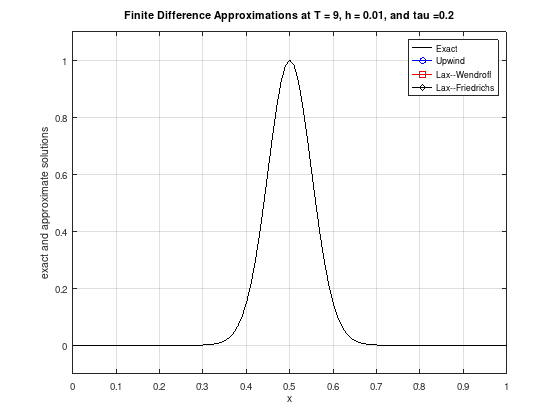

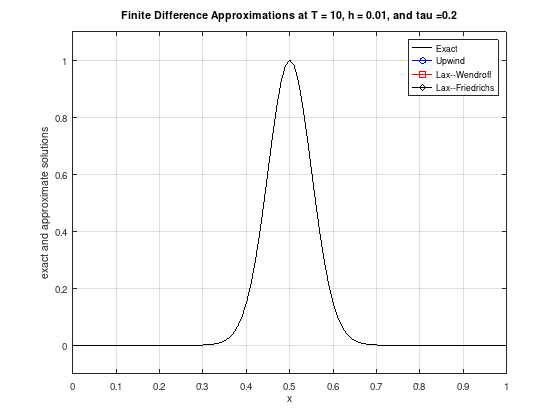

In [5]:
[errorUW, errorLW, errorLF] = AdvectionPer(finalT, N, K, numPlots, typeInit)